# Experiment - Efficient ETF pricing
##### Joao Rodrigues

All necessary imports:

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
from numpy.random import default_rng
pd.set_option('mode.chained_assignment', None)

## Generic data preparation

Let's import a real fixed-income ETF composition file, downloaded from the iShares website

In [2]:
filename = "JPEA_holdings.csv"

In [3]:
holdings = pd.read_csv(
    filename,
    header = 2)

Let's look at the ETF holdings:

In [4]:
holdings

,Issuer Ticker,Name,Asset Class,Weight (%),Price,Nominal,Market Value,Notional Value,Sector,ISIN,Coupon (%),Maturity,Exchange,Location,Market Currency,Duration
0,USD,USD CASH,Cash,2.83,100.00,"284,531,412.00","284,531,411.54","284,531,411.54",Cash and/or Derivatives,-,0.00,-,-,United States,USD,0.00
1,ECUA,ECUADOR REPUBLIC OF (GOVERNMENT) RegS,Fixed Income,0.83,68.75,"121,919,614.00","83,850,214.53","83,850,214.53",Sovereign,XS2214238441,1.00,31/Jul/2035,-,Ecuador,USD,8.75
2,RUSSIA,RUSSIAN FEDERATION RegS,Fixed Income,0.82,128.71,"64,000,000.00","82,801,333.33","82,801,333.33",Sovereign,RU000A0JXU14,5.25,23/Jun/2047,-,Russian Federation,USD,15.26
3,URUGUA,URUGUAY (ORIENTAL REPUBLIC OF),Fixed Income,0.74,131.18,"56,833,766.00","74,962,316.51","74,962,316.51",Sovereign,US760942BA98,5.10,18/Jun/2050,-,Uruguay,USD,16.17
4,KUWIB,KUWAIT STATE OF (GOVERNMENT) MTN RegS,Fixed Income,0.72,111.61,"64,110,000.00","72,421,149.17","72,421,149.17",Sovereign,XS1582346968,3.50,20/Mar/2027,-,Kuwait,USD,5.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,CHF,CHF CASH,Cash,0.00,108.75,"23,549.00","25,609.27","25,609.27",Cash and/or Derivatives,-,0.00,-,-,Switzerland,CHF,0.00
570,EUR,EUR CASH,Cash,0.00,117.45,952.00,"1,118.50","1,118.50",Cash and/or Derivatives,-,0.00,-,-,European Union,EUR,0.00
571,GBP,GBP/USD,FX,0.00,1.00,"198,247,300.00",0.00,0.00,Cash and/or Derivatives,-,0.00,11/Aug/2021,-,United States,USD,0.00
572,GBP,GBP CASH,Cash,-2.72,138.48,"-197,984,325.00","-274,168,693.68","-274,168,693.68",Cash and/or Derivatives,-,0.00,-,-,United Kingdom,GBP,0.00


Let's delete the last row with NaN

In [5]:
holdings.dropna(
    inplace     = True)

In [6]:
holdings["Weight (%)"].sum()

99.9

Weights do not sum up to 1 exactly, probably due to rounding errors in the composition file

Some securities do not have a unique ISIN identifier. Let associate a "fake" ISIN identifier to them.

In [7]:
for row in holdings.loc[holdings["ISIN"]=="-"].itertuples():
    holdings.loc[row.Index, "ISIN"] = "ABC"+str(row.Index)

In [8]:
holdings

,Issuer Ticker,Name,Asset Class,Weight (%),Price,Nominal,Market Value,Notional Value,Sector,ISIN,Coupon (%),Maturity,Exchange,Location,Market Currency,Duration
0,USD,USD CASH,Cash,2.83,100.00,"284,531,412.00","284,531,411.54","284,531,411.54",Cash and/or Derivatives,ABC0,0.00,-,-,United States,USD,0.00
1,ECUA,ECUADOR REPUBLIC OF (GOVERNMENT) RegS,Fixed Income,0.83,68.75,"121,919,614.00","83,850,214.53","83,850,214.53",Sovereign,XS2214238441,1.00,31/Jul/2035,-,Ecuador,USD,8.75
2,RUSSIA,RUSSIAN FEDERATION RegS,Fixed Income,0.82,128.71,"64,000,000.00","82,801,333.33","82,801,333.33",Sovereign,RU000A0JXU14,5.25,23/Jun/2047,-,Russian Federation,USD,15.26
3,URUGUA,URUGUAY (ORIENTAL REPUBLIC OF),Fixed Income,0.74,131.18,"56,833,766.00","74,962,316.51","74,962,316.51",Sovereign,US760942BA98,5.10,18/Jun/2050,-,Uruguay,USD,16.17
4,KUWIB,KUWAIT STATE OF (GOVERNMENT) MTN RegS,Fixed Income,0.72,111.61,"64,110,000.00","72,421,149.17","72,421,149.17",Sovereign,XS1582346968,3.50,20/Mar/2027,-,Kuwait,USD,5.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,MXN,MXN CASH,Cash,0.00,4.97,"3,330,911.00","165,599.56","165,599.56",Cash and/or Derivatives,ABC568,0.00,-,-,Mexico,MXN,0.00
569,CHF,CHF CASH,Cash,0.00,108.75,"23,549.00","25,609.27","25,609.27",Cash and/or Derivatives,ABC569,0.00,-,-,Switzerland,CHF,0.00
570,EUR,EUR CASH,Cash,0.00,117.45,952.00,"1,118.50","1,118.50",Cash and/or Derivatives,ABC570,0.00,-,-,European Union,EUR,0.00
571,GBP,GBP/USD,FX,0.00,1.00,"198,247,300.00",0.00,0.00,Cash and/or Derivatives,ABC571,0.00,11/Aug/2021,-,United States,USD,0.00


In [9]:
print("Number of securities in ETF:  ", len(holdings))
print("Number of unique identifiers: ", len(set(holdings["ISIN"])))

Number of securities in ETF:   573
Number of unique identifiers:  573


Let's make the ISIN identifier the index of the holdings data frame. We will be interested in implementing an efficient scheme to update the NAV of the ETF when one or more of the constituint securities change price. 

By indexing the data frame with the unique ISIN identifier, we can easily search for a specific security in the data frame in constant time, meaning complexity O(1).

In [10]:
holdings.set_index(
    keys    = "ISIN",
    drop    = True,
    inplace = True)

Also, we are only going to need the weight of each security, the "initial" price and the market currency

In [11]:
holdings["Weight"] = 0.01*holdings[r"Weight (%)"]

In [12]:
holdings = holdings[["Weight", "Price", "Market Currency"]]

In [13]:
holdings

,Weight,Price,Market Currency
ISIN,,,
ABC0,0.0283,100.00,USD
XS2214238441,0.0083,68.75,USD
RU000A0JXU14,0.0082,128.71,USD
US760942BA98,0.0074,131.18,USD
XS1582346968,0.0072,111.61,USD
...,...,...,...
ABC568,0.0000,4.97,MXN
ABC569,0.0000,108.75,CHF
ABC570,0.0000,117.45,EUR


Some of the securities are listed in different currencies. However, when traded on an exchange, the ETF will always be quoted on a specific currency. I want to calculate the NAV always in USD. I'm going to create a "random" table of exchange rates. In reality, every time the exchange rate changes I may need to update my ETF NAV. Here, for the sake of simplicity, I will assume fixed exchange rates:

In [14]:
set(holdings["Market Currency"])

{'CHF', 'EUR', 'GBP', 'MXN', 'USD'}

Exchange rates will be defined on a dictionary (hash table), so they can be access/modified in constant time.

In [15]:
X_USD = { # This will be the USD value of the "X" currency
    "USD": 1.0,
    "CHF": 1.1,
    "EUR": 1.2,
    "GBP": 1.4,
    "MXN": 0.05,
}

## ETF object abstraction

Let's create a class, whose objects will be the diffenrent ETFs.
These object will contain 2 methods to update the ETF NAV upon price changes of the constituent securities. These methods are:

 - **update_NAV_method1**: Uses data frames, which store the constituent's price, weight and market currency. The ISIN unique identifier is used as an index. Price search/modification should run in constant time O(1). 
 
 - **update_NAV_method2**: Uses dictionaries. Three different dictionaries store the constituent's price, weight and market currency. The ISIN is used as key for all these dictionaries. Price search/modification should run in constant time O(1). 
 
Both these methods take as single argument a dictionary - *new_prices* - containing the securities which have undergone price change, in the form: {ISIN: new price}. We can then handle multiple price changes in one call to the update NAV methods.

The ETF is implemented below:

In [16]:
class ETF():
    
    """
    ETF class.

    Attributes
    ----------
    composition : DataFrame
        Data frame with weights, price and market currency of each security in the ETF
    NAV : float
        Net Asset Value (in USD)
    exchange_rates : dict
        Exchange rate into USD

    Methods
    -------
    construct():
        Constructs the initial ETF value.
    update_NAV_method1():
        Updates the current ETF NAV, using data frames.
    update_NAV_method2():
        Updates the current ETF NAV, using dictionaries.
    get_NAV():
        Returns the current ETF NAV.
    __str__():
        Prints the current ETF NAV.
    """
    
    def __init__(self):
        self.composition    = None
        self.NAV            = None
        self.exchange_rates = None
        
        
    def construct(self, composition, exchange_rates):
        
        """
        Constructs the initial ETF value.
        
            Parameters:
                composition (DataFrame): Data Frame with the constituents of the ETF.
                exchange_rates (dict): Dictionary with the exchange rates to USD.
            
        """
        
        # Encapsulates the holdings data frame and the exchange rate dictionary
        self.composition = composition.copy(deep=True)
        self.exchange_rates = copy.deepcopy(exchange_rates)
        
        # Creates dictionaries (hash tables) for storing the ETF securities price, weight and market currency
        self.composition_price    = self.composition["Price"].to_dict()
        self.composition_weight   = self.composition["Weight"].to_dict()
        self.composition_currency = self.composition["Market Currency"].to_dict()
        
        # Calculates the inital ETF NAV
        self.NAV = self.composition.apply(
            lambda row: row["Weight"]*row["Price"]*self.exchange_rates[row["Market Currency"]], 
            axis=1).sum()
    
        
    def update_NAV_method1(self, new_prices):

        """
        Updates the current ETF NAV, given a change price of one (or more) of the constituent securities.
        Uses DataFrame native indexing to handle the updates
        
            Parameters:
                new_prices (dict): Dictionary with (key, value) = (ISIN, updated price)
            
        """
        
        for security, new_price in new_prices.items():
            self.NAV += self.composition.loc[security, "Weight"] * (new_price-self.composition.loc[security, "Price"]) * \
                        self.exchange_rates[self.composition.loc[security, "Market Currency"]]
            self.composition.loc[security, "Price"] = new_price
    
    
    def update_NAV_method2(self, new_prices):

        """
        Updates the current ETF NAV, given a change price of one (or more) of the constituent securities.
        Uses dictionaries (hash tables).
        
            Parameters:
                new_prices (dict): Dictionary with (key, value) = (ISIN, updated price)
            
        """
        
        for security, new_price in new_prices.items():
            self.NAV += self.composition_weight[security] * (new_price-self.composition_price[security]) * \
                        self.exchange_rates[self.composition_currency[security]]
            self.composition_price[security] = new_price
        
    
    def get_NAV(self):
        
        """
        Returns the current ETF NAV.
        """
        
        return(self.NAV)
    
    
    def __str__(self):
        
        """
        Prints the current ETF NAV.
        """ 
        
        return("Current ETF's NAV = "+str(self.NAV)+" USD")

Let's now see how to use object of the *ETF* type:

In [17]:
jpea_1 = ETF()
jpea_2 = ETF()

We now send the data frame containing the ETF holdings, as well as the previously defined dictionary of exchange rates to the *construct* method. Besides encapsulating these quantities and creating the necessary dictionaries used to update the NAV, it will also calculate the "initial" ETF value:

In [18]:
jpea_1.construct(
    composition    = holdings,
    exchange_rates = X_USD)
jpea_2.construct(
    composition    = holdings,
    exchange_rates = X_USD)

Let's check the ETF's initial value:

In [19]:
print(jpea_1)
print(jpea_2)

Current ETF's NAV = 105.8180466 USD
Current ETF's NAV = 105.8180466 USD


Let's now simulate a price change in two of the ETF's holdings, and update the its NAV using the two methods described above:

In [20]:
new_prices = {
    holdings.index[1]: holdings.iloc[1]["Price"]+1/holdings.iloc[1]["Weight"],
    holdings.index[2]: holdings.iloc[2]["Price"]+5/holdings.iloc[2]["Weight"]
} # the price change is engineered to increase the NAV value by 6 USD

In [21]:
jpea_1.update_NAV_method1(
    new_prices = new_prices)

In [22]:
jpea_2.update_NAV_method2(
    new_prices = new_prices)

In [23]:
print(jpea_1)

Current ETF's NAV = 111.8180466 USD


In [24]:
print(jpea_2)

Current ETF's NAV = 111.8180466 USD


## Performance Analysis

Let's now run some experiments to test the performance of our ETF value updating methods:
We will begin by using the real JPEA holdings imported above:

### Real ETF

In order to make all the results here reproducible, I will use a random generator with fixed seed:

In [25]:
rng = default_rng(seed=41)

Let's set some parameter for the experiment:

In [26]:
N = 1e3     # Number of NAV updating iterations
p = 0.01    # Probability of a price change of each security, at each iteration

# Price changes will be drawn from a normal distribution with the following mean and std values:
dp_mean = 0
dp_std  = 1

I want to test both methods on exactly the same set of operations. Let's create two ETF objects with exactly the same holdings:

In [27]:
etf1 = ETF()
etf1.construct(
    composition    = holdings,
    exchange_rates = X_USD)

etf2 = ETF()
etf2.construct(
    composition    = holdings,
    exchange_rates = X_USD)

Let's now create a function that simulates N iterations of NAV updates. Details are shown as comments on the code:

**Note:** While I have tried to optimized the ETF class for numerical efficiency, the following set of routines that implement the simulation have not been optimized for efficiency.

In [28]:
def estimate_NAV_updating_time(N, p, dp_mean, dp_std, etf1, etf2, n_price_changes=None):
    
    # Initializes lists to store ETF NAV updateing times, for both methods described before
    update_times_df   = []
    update_times_hash = []
    
    for i in range(0, int(N)):

        # Number of securities that have undergone price change.
        # If n_price_changes is None, the number of price changes is drawn from a binomial distribution, where we
        # ... consider a 0.01 probability of each security changing price. Otherwise,
        # ... it uses the value provided to the n_price_changes argument.
        if n_price_changes is None:
            n_price_changes = rng.binomial(
                n    = len(etf1.composition),
                p    = p,
                size = 1)
        
        # Draws which securities changed price
        inds = rng.integers(
            low  = 0,
            high = len(etf1.composition)-1,
            size = n_price_changes)

        # Simulates the new_prices dictionary, as described before
        price_changes = rng.normal(
                    loc   = dp_mean,
                    scale = dp_std,
                    size  = n_price_changes)
        new_prices = dict()
        for j, ind in enumerate(inds):
            new_prices.update(
                {etf1.composition.index[ind]: etf1.composition.iloc[ind]["Price"]+price_changes[j]})

        # Updates and ETF 1 NAV value, using DataFrame indexing - method 1
        t1 = time.time()
        etf1.update_NAV_method1(
            new_prices = new_prices)
        t2 = time.time()
        update_times_df.append(t2-t1)
            
        # Updates and ETF 2 NAV value, using dictionaries (hash tables) - method 2. 
        t1 = time.time()
        etf2.update_NAV_method2(
            new_prices = new_prices)
        t2 = time.time()
        update_times_hash.append(t2-t1)
        
        
    return update_times_df, update_times_hash

Let's now run the simulation

In [29]:
update_times_df, update_times_hash = estimate_NAV_updating_time(
    N               = N, 
    p               = p, 
    dp_mean         = dp_mean, 
    dp_std          = dp_std,
    etf1            = etf1,
    etf2            = etf2,
    n_price_changes = None)

update_times = np.array([update_times_df, update_times_hash]).T

And plot the results:

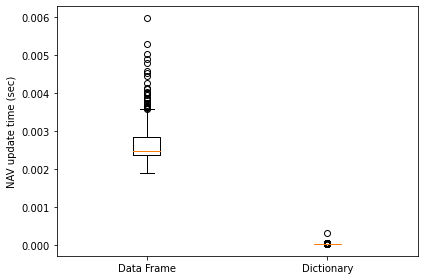

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.boxplot(update_times)
axes.set_xticklabels(["Data Frame", "Dictionary"], rotation=0)
axes.set_ylabel("NAV update time (sec)")
plt.tight_layout()
plt.show()

In [31]:
print("Average update time using Data Frames:  ", np.mean(update_times_df))
print("Average update time using Dictionaries: ", np.mean(update_times_hash))
print("Ratio:                                  ", np.mean(update_times_df)/np.mean(update_times_hash))

Average update time using Data Frames:   0.0026380674839019775
Average update time using Dictionaries:  1.3316154479980468e-05
Ratio:                                   198.11030938909977


It seems that method 2 (using dictionaries) highly outperforms the data frame indexing. 

To make sure we have perform exacly the same operations on both etf1 and etf2, let's print the final NAV of both:

In [32]:
print(etf1)
print(etf2)

Current ETF's NAV = 105.73044187849463 USD
Current ETF's NAV = 105.73044187849463 USD


Since we are using a binomial distribution to sample the number of price changes per NAV update iteration, the NAV updating time should reflect this. Let's now repeat the experiment, but fixing the number of price changes per NAV update to 5:

In [33]:
update_times_df, update_times_hash = estimate_NAV_updating_time(
    N               = N, 
    p               = p, 
    dp_mean         = dp_mean, 
    dp_std          = dp_std,
    etf1            = etf1,
    etf2            = etf2,
    n_price_changes = 5)

update_times = np.array([update_times_df, update_times_hash]).T

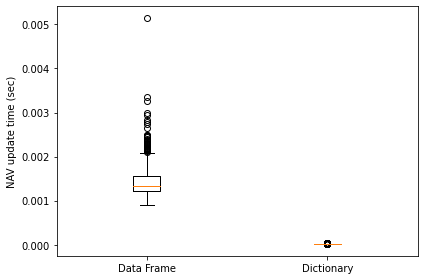

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
axes.boxplot(update_times)
axes.set_xticklabels(["Data Frame", "Dictionary"], rotation=0)
axes.set_ylabel("NAV update time (sec)")
plt.tight_layout()
plt.show()

In [35]:
print("Average update time using Data Frames:  ", np.mean(update_times_df))
print("Average update time using Dictionaries: ", np.mean(update_times_hash))
print("Ratio:                                  ", np.mean(update_times_df)/np.mean(update_times_hash))

Average update time using Data Frames:   0.001434631586074829
Average update time using Dictionaries:  9.687185287475586e-06
Ratio:                                   148.09581354138464


### Simulated ETF's

I now want to run to general experiments, including running efficiency tests on different sized ETF's. To do so, I need to be able to generate random ETF holdings. The following function generates a random holdings data frame for a synthetic ETF composed of *n_securities*:

In [36]:
def generate_ETF_holdings(n_securities, rng):
        
    # Draws weights from uniform distribution
    weights = rng.uniform(
        low  = 0,
        high = 1,
        size = n_securities)
    weights = weights / weights.sum()
    
    # Draws the initial securities prices, sampled from a normal distribution of mean 100 and std 1
    prices = rng.normal(
        loc   = 100,
        scale = 1,
        size  = n_securities)
    
    # Creates the unique identifiers
    unique_ids = ["Security"+str(i) for i in range(0, n_securities)]
        
    # Creates the ETF holdings data frame
    holdings = pd.DataFrame(
        index = unique_ids)
    holdings.index.name = "ISIN"
    holdings["Price"]           = prices
    holdings["Weight"]          = weights
    holdings["Market Currency"] = "USD"
    
    return holdings

Let's see one example:

In [37]:
n_securities = 10

In [38]:
generate_ETF_holdings(
    n_securities = n_securities,
    rng          = rng)

,Price,Weight,Market Currency
ISIN,,,
Security0,100.051491,0.015638,USD
Security1,100.349253,0.113749,USD
Security2,98.383032,0.145440,USD
Security3,100.510631,0.005047,USD
Security4,99.590367,0.070827,USD
Security5,99.148061,0.049436,USD
Security6,100.169402,0.144271,USD
Security7,99.867898,0.048545,USD
Security8,100.459193,0.158167,USD


I want to now essentially repeat the experiment of the previous section, but considering ETFs of different sizes:

In [39]:
n_securities_vals = np.sort(np.array(list(set(np.array(10**np.arange(1, 3.5, 0.025), dtype=int))), dtype=int))

The following function essentially wraps the simulation conducted above and repeats it for different sized ETF's. For each synthetic holdings, it returns the average NAV updating time of both methods described vefore, over N value update iterations.

In [40]:
def estimate_NAV_updating_time_scaling(N, p, dp_mean, dp_std, n_price_changes, n_securities_vals, rng):

    average_update_time_df   = []
    average_update_time_hash = []

    for n_securities in tqdm(n_securities_vals):

        # Generates random ETF's holdings
        synthetic_holdings = generate_ETF_holdings(
            n_securities = n_securities,
            rng          = rng)

        # Initiates the ETF objects
        etf1 = ETF()
        etf1.construct(
            composition    = synthetic_holdings,
            exchange_rates = X_USD)

        etf2 = ETF()
        etf2.construct(
            composition    = synthetic_holdings,
            exchange_rates = X_USD)
        
        # Simulates NAV updating times
        update_times_df, update_times_hash = estimate_NAV_updating_time(
        N               = N, 
        p               = p, 
        dp_mean         = dp_mean, 
        dp_std          = dp_std,
        etf1            = etf1,
        etf2            = etf2,
        n_price_changes = n_price_changes)

        # Calculates average updating times for both schemes
        average_update_time_df.append(np.mean(update_times_df))
        average_update_time_hash.append(np.mean(update_times_hash))

    average_update_time_df   = np.array(average_update_time_df)
    average_update_time_hash = np.array(average_update_time_hash)
    
    return average_update_time_df, average_update_time_hash, etf1, etf2

Let's now run the simulation, first considering the number of price changes per NAV update itearation to be drawn from binomial distribution, as described before

In [41]:
average_update_time_df, average_update_time_hash, etf1, etf2 = estimate_NAV_updating_time_scaling(
    N                 = N, 
    p                 = p, 
    dp_mean           = dp_mean, 
    dp_std            = dp_std, 
    n_price_changes   = None, # number of prices changes per NAV update iteration is drawn from binomial distribution
    n_securities_vals = n_securities_vals,
    rng               = rng)

100%|██████████| 97/97 [03:01<00:00,  1.87s/it]


Plotting the results:

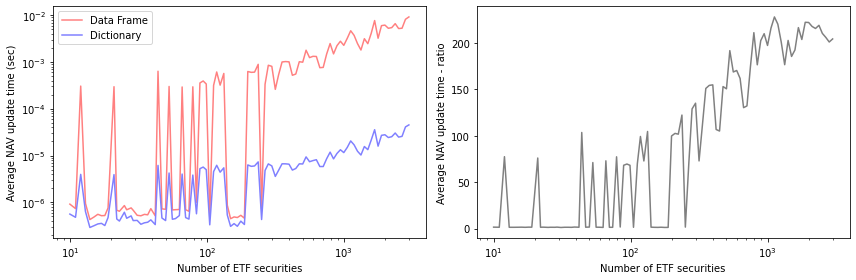

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(n_securities_vals, average_update_time_df, label="Data Frame", color=(1.0,0.5,0.5))
axes[0].plot(n_securities_vals, average_update_time_hash, label="Dictionary", color=(0.5,0.5,1.0))
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].legend()
axes[0].set_ylabel("Average NAV update time (sec)")
axes[0].set_xlabel("Number of ETF securities")

axes[1].plot(n_securities_vals, average_update_time_df/average_update_time_hash, color=(0.5,0.5,0.5))
axes[1].set_ylabel("Average NAV update time - ratio")
axes[1].set_xlabel("Number of ETF securities")
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()

Few notes:

- For larger ETFs, method 2 (based on dictionaries) maintains a 200x faster updading time than using native data frame indexing.

- It seems that the efficiency difference is more pronounced for larger ETF's. This will be re-examined below.

- Both methods seems to scale linearly with the ETF's size. This is an resul of how we conduct the simulation. Given that we are drawing the number of constituent price changes per iteration from a binomial distribution with parameter $p=0.01$, the average number of price changes per iteration grows linearly with the ETF's size. In both cases, the "single price change updating time" is kept at constant time. To verify this, let's repeat the experiment above, but considering only a single constituent price change per NAV update iteration:

In [43]:
average_update_time_df, average_update_time_hash, etf1, etf2 = estimate_NAV_updating_time_scaling(
    N                 = N, 
    p                 = p, 
    dp_mean           = dp_mean, 
    dp_std            = dp_std, 
    n_price_changes   = 1,  # Single price change per NAV update iteration
    n_securities_vals = n_securities_vals,
    rng               = rng)

100%|██████████| 97/97 [00:51<00:00,  1.87it/s]


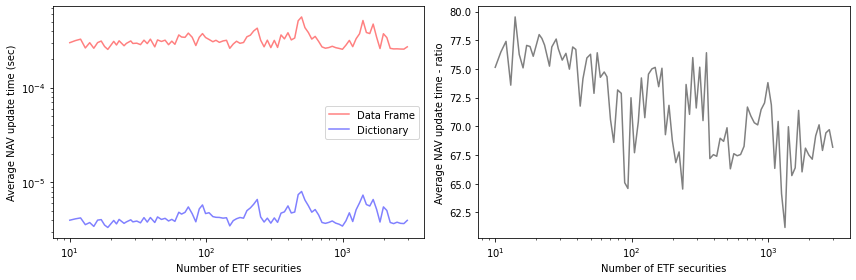

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(n_securities_vals, average_update_time_df, label="Data Frame", color=(1.0,0.5,0.5))
axes[0].plot(n_securities_vals, average_update_time_hash, label="Dictionary", color=(0.5,0.5,1.0))
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].legend()
axes[0].set_ylabel("Average NAV update time (sec)")
axes[0].set_xlabel("Number of ETF securities")

axes[1].plot(n_securities_vals, average_update_time_df/average_update_time_hash, color=(0.5,0.5,0.5))
axes[1].set_ylabel("Average NAV update time - ratio")
axes[1].set_xlabel("Number of ETF securities")
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()

- The dictionaty method still outperforms the data frame method.
- The NAV update time seems to no longer scale with the ETF size or, at least, scale in a very slow manner, probably due to other overheads involved in the operation.
- The difference of efficiencies between the two methods seems to slightly decrease for larger ETFs. Let's repeat the experiment, but change the number of price changes per NAV iteration from 1 to 10:

In [45]:
average_update_time_df, average_update_time_hash, etf1, etf2 = estimate_NAV_updating_time_scaling(
    N                 = N, 
    p                 = p, 
    dp_mean           = dp_mean, 
    dp_std            = dp_std, 
    n_price_changes   = 10,  # Single price change per NAV update iteration
    n_securities_vals = n_securities_vals,
    rng               = rng)

100%|██████████| 97/97 [05:28<00:00,  3.39s/it]


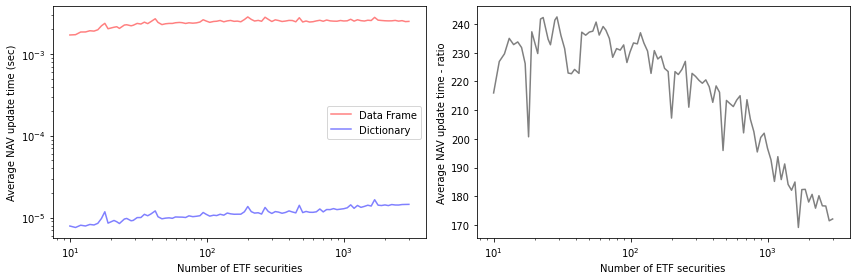

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(n_securities_vals, average_update_time_df, label="Data Frame", color=(1.0,0.5,0.5))
axes[0].plot(n_securities_vals, average_update_time_hash, label="Dictionary", color=(0.5,0.5,1.0))
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].legend()
axes[0].set_ylabel("Average NAV update time (sec)")
axes[0].set_xlabel("Number of ETF securities")

axes[1].plot(n_securities_vals, average_update_time_df/average_update_time_hash, color=(0.5,0.5,0.5))
axes[1].set_ylabel("Average NAV update time - ratio")
axes[1].set_xlabel("Number of ETF securities")
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()

- The overall efficiency difference increases, but we stil observe a decrease of the efficincy difference as we increase the ETF size. There seems to be a slight scaling on the method2 with the ETF size. I haven't fully figured out the reason behind it. Let's at least see if this scaling saturates at larger ETF size:

In [47]:
n_securities_vals = np.sort(np.array(list(set(np.array(10**np.arange(1, 6, 0.25), dtype=int))), dtype=int))

In [48]:
average_update_time_df, average_update_time_hash, etf1, etf2 = estimate_NAV_updating_time_scaling(
    N                 = N, 
    p                 = p, 
    dp_mean           = dp_mean, 
    dp_std            = dp_std, 
    n_price_changes   = 1,  # Single price change per NAV update iteration
    n_securities_vals = n_securities_vals,
    rng               = rng)

100%|██████████| 20/20 [01:21<00:00,  4.07s/it]


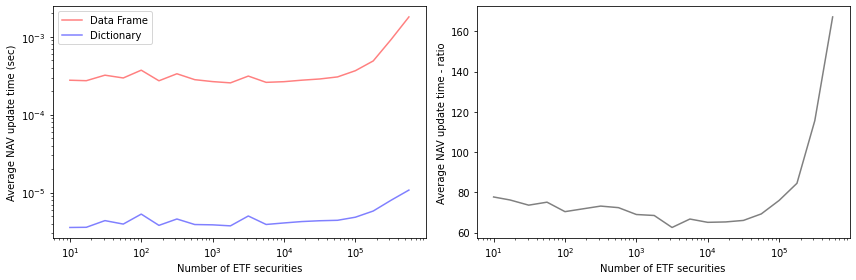

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(n_securities_vals, average_update_time_df, label="Data Frame", color=(1.0,0.5,0.5))
axes[0].plot(n_securities_vals, average_update_time_hash, label="Dictionary", color=(0.5,0.5,1.0))
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].legend()
axes[0].set_ylabel("Average NAV update time (sec)")
axes[0].set_xlabel("Number of ETF securities")

axes[1].plot(n_securities_vals, average_update_time_df/average_update_time_hash, color=(0.5,0.5,0.5))
axes[1].set_ylabel("Average NAV update time - ratio")
axes[1].set_xlabel("Number of ETF securities")
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()

It seems that the efficiency different not only does not saturate, but it is actually non-monotonic. This needs further examination.

**Note**: Despite fixing the random seed, the results will not be exactly reproducible because when timing the function calls, the result will partially depend on external factors to the code. Also, greater efforts still have to be made to make sure the results depend only on the specific implementation of the NAV update methods, and not on the way the simulations are conducted.